# Train a single-task regression model from scratch

In this tutorial, we train a single-task convolutional regression model to predict total coverage over DNase-seq peaks, starting from ENCODE DNase-seq read coverage file.

In [1]:
# ! pip install git+https://github.com/genentech/grelu

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set experiment parameters

In [4]:
experiment='train_GM12878_DNase'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Peak and fragment files

We downloaded pseudobulk scATAC data for https://www.encodeproject.org/experiments/ENCSR000EJD/:

In [5]:
import grelu

In [6]:
grelu.__version__

'1.0.2.post1.dev12+g19b6e99'

In [5]:
import grelu.resources

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Paths to files
peak_file = os.path.join("./data/ENCFF588OCA.summit.500bp.narrowPeak")
bw_file = "./data/downloads/ENCFF093VXI.bw"

## Set parameters

In [7]:
seq_len=2114 # Length of the input sequence
label_len=1000 # Length over which we calculate total coverage
val_chroms=["chr10"]
test_chroms=["chr11"]
genome="hg38"

## Read peak file

We read peak coordinates from the narrowPeak file.

In [8]:
import grelu.io.bed

peaks = grelu.io.bed.read_narrowpeak(peak_file)
peaks.tail(3)

,chrom,start,end,name,score,strand,signal,pvalue,qvalue,summit
230418,chrY,56839080,56839580,.,.,.,.,.,.,250
230419,chrY,56840592,56841242,.,.,.,.,.,.,325
230420,chrY,56849849,56850349,.,.,.,.,.,.,250


## Summit-center peaks

We extract the genomic coordinates for the 2114 bases surrounding the summit of each peak.

In [9]:
import grelu.data.preprocess

peaks = grelu.data.preprocess.extend_from_coord(
    peaks,
    seq_len=seq_len,
    center_col="summit"
)
peaks.tail(3)

,chrom,start,end
230418,chrY,56838273,56840387
230419,chrY,56839860,56841974
230420,chrY,56849042,56851156


In [10]:
len(peaks)

230421

## Filter peaks

In [11]:
# Filter peaks outside autosomes
# Change to "autosomesX" or "autosomesXY" to include sex chromosomes
peaks = grelu.data.preprocess.filter_chromosomes(peaks, 'autosomes')

Keeping 223259 intervals


In [12]:
# Filter peaks close to blacklist regions
peaks = grelu.data.preprocess.filter_blacklist(
    peaks,
    genome=genome,
    window=50 # Remove peaks if they are within 50 bp of a blacklist region
)

Keeping 222151 intervals


## Get GC matched negative regions

To ensure that the model also learns to recognize regions that are not peaks, we will include a set of "negative" (non-peak) regions with similar GC content to the peaks.

In [13]:
negatives = grelu.data.preprocess.get_gc_matched_intervals(
    peaks,
    binwidth=0.05, # resolution of measuring GC content
    genome=genome,
    chroms="autosomes", # negative regions will also be chosen from autosomes
    # gc_bw_file='gc_hg38_2114.bw',
    blacklist=genome, # negative regions overlapping the blacklist will be dropped
)
negatives.head(3)

18:03:18 | INFO | Downloading assembly summaries from GENCODE
18:03:49 | INFO | Downloading assembly summaries from UCSC
18:03:52 | INFO | Downloading assembly summaries from Ensembl
18:04:09 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...
Download: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938M/938M [00:09<00:00, 106MB/s]
18:04:18 | INFO | Genome download successful, starting post processing...
18:04:35 | INFO | name: hg38
18:04:35 | INFO | local name: hg38
18:04:35 | INFO | fasta: /root/.local/share/genomes/hg38/hg38.fa
Filtering Fasta: 64.2M lines [00:20, 3.12M lines/s]


Extracting matching intervals


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222151/222151 [00:32<00:00, 6744.09it/s]


GC paired t-test: 0.122, 0.0
Filtering blacklist
Keeping 214650 intervals


,chrom,start,end
0,chr9,36850274,36852388
1,chr14,72687664,72689778
2,chr1,208511064,208513178


We can visualize a histogram of GC content in the peaks and negative regions to verify that they are similar.

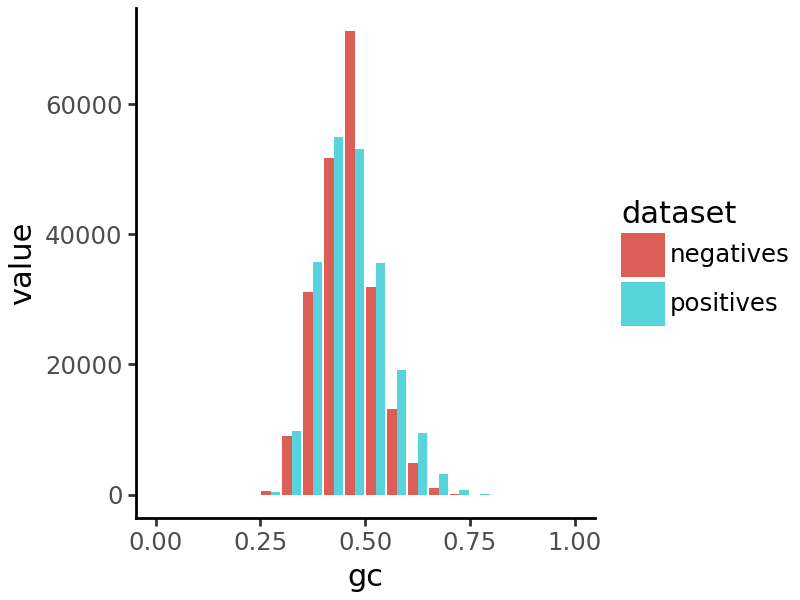

In [14]:
import grelu.visualize
grelu.visualize.plot_gc_match(
    positives=peaks, negatives=negatives, binwidth=0.05, genome="hg38"
)

## Combine peaks and negative regions

The full dataset includes both peaks and negative regions.

In [15]:
regions = pd.concat([peaks, negatives])

In [16]:
regions.shape

(436801, 3)

## Split data by chromosome

We now split the dataset by chromosome to create separate datasets for training, validation and testing.

In [17]:
train, val, test = grelu.data.preprocess.split(
    regions, val_chroms=val_chroms, test_chroms=test_chroms)

Selecting training samples
Keeping 392993 intervals


Selecting validation samples
Keeping 21560 intervals


Selecting test samples
Keeping 22248 intervals
Final sizes: train: (353985, 3), val: (1341, 3), test: (1449, 3)


## Make labeled datasets

We now make pytorch dataset objects in order to load paired sequences and coverage values from the genome and the bigWig file. We use the `BigWigSeqDataset` class.

We first make the training dataset. To increase model robustness we use several forms of data augmentation here: `rc=True` (reverse complementing the input sequence), `max_seq_shift=3` (shifting the coordinates of the input sequence by upto 3 bp in either direction; also known as jitter), and `max_pair_shift=50` (shifting both the input sequence and the region for which to calculate coverage by upto 50 bp in either direction).

Further, we use `label_aggfunc="sum"` which means that the label will be the summed coverage over the central region of the interval.

In [18]:
import grelu.data.dataset

train_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = train,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    label_transform_func=np.log1p,
    rc=True, # reverse complement
    max_seq_shift=3, # Shift the sequence
    max_pair_shift=50, # Shift both sequence and label
    augment_mode="random",
    seed=0,
    genome=genome
)

We do not apply any augmentations to the validation and test datasets (although it is possible to do so).

In [19]:
val_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = val,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum", 
    label_transform_func=np.log1p,
    genome=genome
)

In [20]:
test_ds = grelu.data.dataset.BigWigSeqDataset(
    intervals = test,
    bw_files=[bw_file],
    label_len=label_len,
    label_aggfunc="sum",
    label_transform_func=np.log1p,
    genome=genome
)

len(train_ds), len(val_ds), len(test_ds)

(353985, 1341, 1449)

## Build model

In [32]:
model_params = {
    'model_type':'DilatedConvModel',
    'crop_len':(seq_len-label_len)//2,
    'n_tasks':1,
    'channels':256,
    'n_conv':9,
}

train_params = {
    'task':'regression',
    'loss': 'mse', 
    'logger':'csv',
    'lr':1e-4,
    'batch_size':128,
    'max_epochs':50,
    'devices':0,
    'num_workers':16,
    'save_dir':experiment,
    'checkpoint': {"monitor":"val_pearson", "mode":"max", "save_last":True}
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

## Train model

In [ ]:
# See the tutorial_3 folder for logs.
trainer = model.train_on_dataset(train_ds, val_ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: train_GM12878_DNase/2024_27_07_00_33
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    21.348608016967773     │
│          val_mse          │     21.37464714050293     │
│        val_pearson        │    -0.2583931088447571    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 1.6 M  | train
1 | loss         | MSELoss          | 0      | train
2 | activation   | Identity         | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
5 | transform    | Identity         | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.388     Total estimated model params size (MB)


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [02:50<00:00, 16.21it/s, v_num=0, train_loss_step=0.520]
Validation: |                                                                                                                                                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2769/2769 [02:50<00:00, 16.26it/s, v_num=0, train_loss_step=0.336, train_loss_epoch=0.912]
Validation: |                                                                                                                                 

## Load the best model version

In [91]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

## Evaluate model

We now evaluate the model's performance on the test dataset.

In [22]:
test_metrics = model.test_on_dataset(
    test_ds,
    batch_size=512,
    devices=0,
    num_workers=8
)

test_metrics

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  0.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3614264130592346     │
│         test_mse          │    0.3638118505477905     │
│       test_pearson        │    0.8008037805557251     │
└───────────────────────────┴───────────────────────────┘

,test_mse,test_pearson
ENCFF093VXI,0.363812,0.800804


## Run inference on held out sequences

We can now get the predicted total coverage for each sequence in the test set.

In [23]:
preds = model.predict_on_dataset(
    test_ds, devices=0, num_workers=8
    )
preds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.14it/s]


(1449, 1, 1)

We can visualize a scatter plot of predicted vs. true coverage values

In [24]:
import scipy.stats

In [25]:
scipy.stats.pearsonr(preds.ravel(), test_ds.get_labels().ravel())

PearsonRResult(statistic=0.8008037846693019, pvalue=0.0)

In [26]:
import matplotlib.pyplot as plt

In [27]:
from plotnine import *

In [56]:
plot = grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_ds.get_labels(),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.1
) + ggtitle("Test set (chr11) prediction") + theme(text = element_text(size = 10), legend_key_size=5)

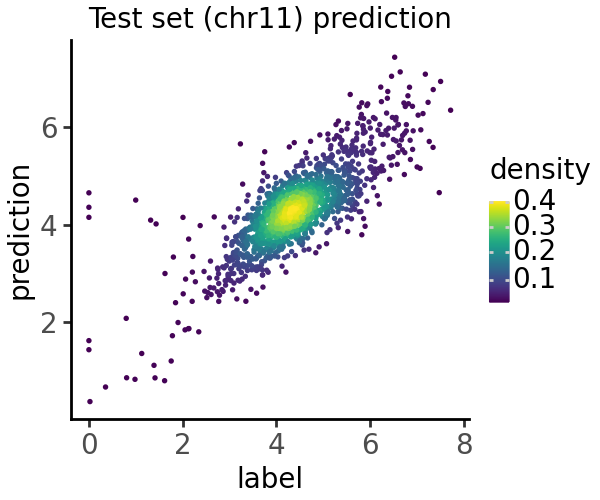

In [60]:
plot

In [61]:
plot.save("test.pdf", dpi=300)

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 2.5 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: test.pdf
